# Setup

In [1]:
!pip install -U -q transformers bitsandbytes accelerate sentence-transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.0 MB/s eta 0:00

In [2]:
from sentence_transformers import SentenceTransformer, util

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

from sklearn.cluster import KMeans

from datasets import load_dataset

from math import sqrt

## Create the sentence-embedder

In [3]:
class SentenceEncoder():
    def __init__(self, model='sentence-transformers/all-MiniLM-L12-v2', device='cuda'):
        self.model = SentenceTransformer(model, device)
        pass
    
    def encode(self, sentences, convert_to_tensor=True):
        return self.model.encode(sentences, convert_to_tensor=convert_to_tensor)

## Method to setup the summarizer pipeline

In [4]:
def create_summarizer_pipeline(params=None):
  default_params = {
                      "max_length": 256,
                      "min_length": 8,
                      "no_repeat_ngram_size": 3,
                      "early_stopping": True,
                      "repetition_penalty": 3.5,
                      "length_penalty": 0.4,
                      "encoder_no_repeat_ngram_size": 3,
                      "num_beams": 4
                } # parameters for text generation out of model
  params = params if params else default_params
  params['load_in_8bit'] = True
  model_name = "pszemraj/long-t5-tglobal-xl-16384-book-summary-8bit"
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
  summarizer = pipeline(task="summarization",\
                        model=model,\
                        tokenizer=tokenizer,\
                        device_map="auto",\
                        model_kwargs=params)
  return summarizer

# Clustering Algorithms

## kmeans

In [5]:
def cluster_k_means(corpus, corpus_embeddings, num_clusters=None):
  if num_clusters is None:
    num_clusters = int(sqrt(len(corpus)))
  clustering_model = KMeans(n_clusters=num_clusters)
  clustering_model.fit(corpus_embeddings)
  cluster_assignment = clustering_model.labels_
  clustered_sentences = [[] for i in range(num_clusters)]
  clustered_embeddings = [[] for i in range(num_clusters)]
  for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])
    clustered_embeddings[cluster_id].append(corpus_embeddings[sentence_id])
  return clustered_sentences, clustered_embeddings, cluster_assignment

# Dimensionality Reduction

## PCA

In [85]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

# Experiment: Quora Duplicate Questions Dataset

In [6]:
def get_quora_questions_slice(slice_n=None):
  sliced_quora = load_dataset("quora", split="train")[:slice_n] if slice_n else load_dataset("quora", split="train")
  labels = sliced_quora['is_duplicate']
  questions = []
  for q in sliced_quora['questions']:
    questions.append(q['text'][0])
    questions.append(q['text'][1])
  return questions, labels

In [7]:
questions, labels = get_quora_questions_slice(slice_n=10000)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

Dataset quora downloaded and prepared to /root/.cache/huggingface/datasets/quora/default/0.0.0/36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04. Subsequent calls will reuse this data.


In [8]:
st = SentenceEncoder()

In [12]:
embed_questions = st.encode(questions)

In [16]:
embed_questions_cpu = embed_questions.detach().cpu().numpy()

In [86]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(embed_questions_cpu)

PCA()

In [87]:
len(pca.explained_variance_ratio_)

384

In [41]:
cdf = [pca.explained_variance_ratio_[0]]
for i in range(1,len(pca.explained_variance_ratio_)):
  cdf.append(cdf[-1] + pca.explained_variance_ratio_[i])

In [89]:
reduced_data = PCA(n_components=200).fit_transform(embed_questions_cpu)

In [98]:
x = reduced_data[0]
x.shape

(200,)

In [101]:
reduced_data.shape

(20000, 200)

In [110]:
import numpy as np
norms = np.linalg.norm(reduced_data, axis=1)
normalized_data = reduced_data/norms.reshape(20000,1)

In [113]:
clustered_sentences, clustered_embeddings, cluster_assignment = cluster_k_means(
    corpus=questions,\
    corpus_embeddings=normalized_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [67]:
kmeans = KMeans(init="k-means++", n_clusters=200, n_init=4)
kmeans.fit(reduced_data)

array([0.9031376 , 0.9014432 , 0.8445676 , ..., 0.8390931 , 0.9170233 ,
       0.88705134], dtype=float32)

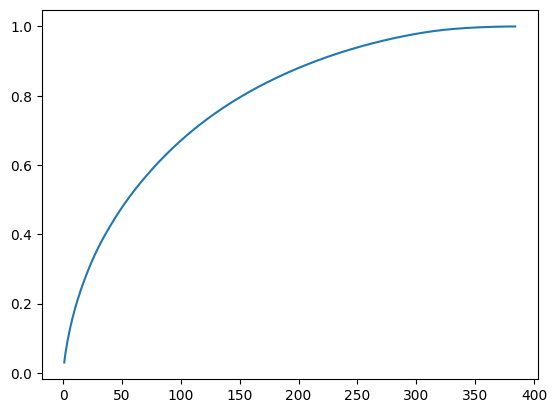

In [43]:
import numpy as np
import matplotlib.pyplot as plt

x,y = [x for x in range(1, len(cdf)+1)], cdf
fig, ax = plt.subplots()
ax.plot(x, y)

In [114]:
cluster_sizes = [len(cluster) for cluster in clustered_sentences]

In [116]:
long_texts = [" ".join(clustered_sentences[i]) for i in range(len(clustered_sentences))]

In [117]:
long_texts[0]

"How do I find a good escort? How do I love my body as a guy? How do I be a boyfriend? How does a girl get a boyfriend? I'm 18. What should I do? What can I do when I'm 18? How do I get a boyfriend for age 13? How can I get a boyfriend at age 13? How do I become an attractive girl? How do you become pretty/attractive? How can I be like Jake Williams? How Can I impress a girl who hate me? How can impress a girl who hate me? What interests should I add on Omegle to get more girls? How do I avoid looking like a tourist in Paris? How do I dress in Paris to avoid looking like a tourist? How do you get noticed? How can I get noticed in Bollywood? what can i do to become fair? How can I become more white? How do I be a silent and impressive person? What is the best way to approach a celebrity? How can I draw myself as an anime character? How do I impress my Would-be Mother-in-law? How do I impress my mother in law? How can I be feminine? How can I be more graceful and feminine? How can I buy 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored